In [ ]:
# Stain_normalize patches in BCNB dataset

import os
from PIL import Image
import numpy as np
import h5py
import random
import matplotlib.pyplot as plt

datafolder = "/home/hu-eki/Data/BCNB/paper_patches"

patches_folder = os.path.join(datafolder, "patches")
target_folder = os.path.join(datafolder, "patches_normalized")
h5_folder = "/home/hu-eki/Projects/HEST/tutorials/hest_data/patches"
h5_cases = ['TENX99', 'TENX96', 'TENX95', 'NCBI783', 'NCBI785']

def plot_reference_patch(reference_patch):
    # Plot the reference patch
    plt.figure(figsize=(5, 5))
    plt.imshow(reference_patch)
    plt.title("Reference Patch")
    plt.axis('off')
    plt.show()
    
    # Plot the color spectrum (histograms for R, G, B channels)
    plt.figure(figsize=(10, 3))
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist, bins = np.histogram(reference_patch[:, :, i].flatten(), bins=256, range=[0, 256])
        plt.plot(bins[:-1], hist, color=color, label=f'{color.upper()} channel')
    plt.title('Color Spectrum')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


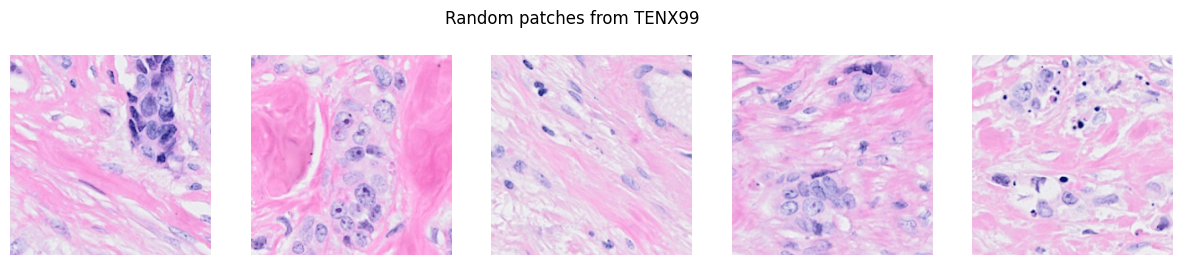

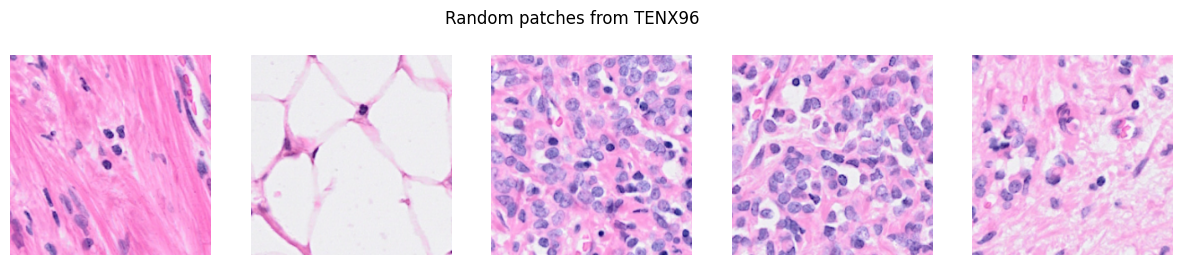

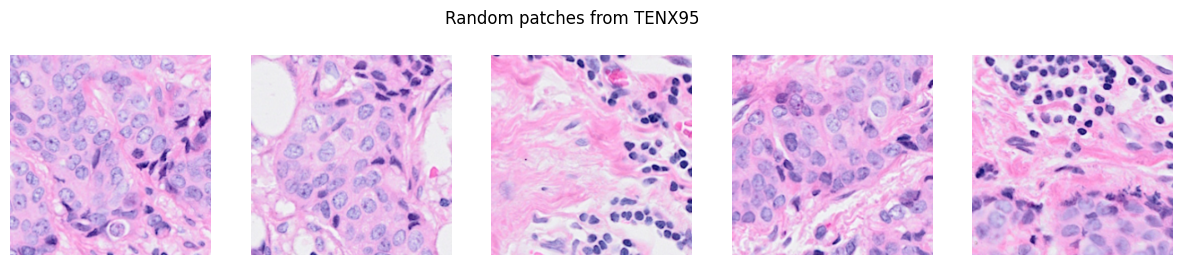

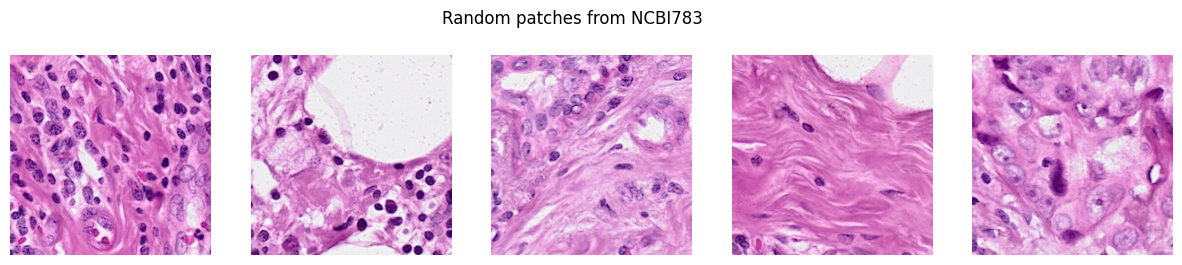

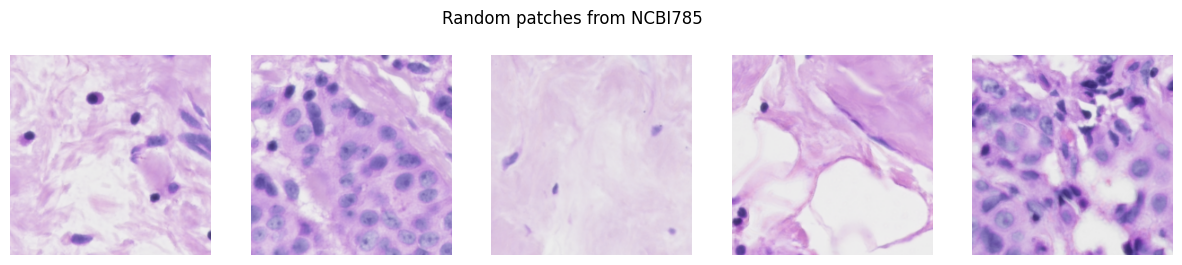

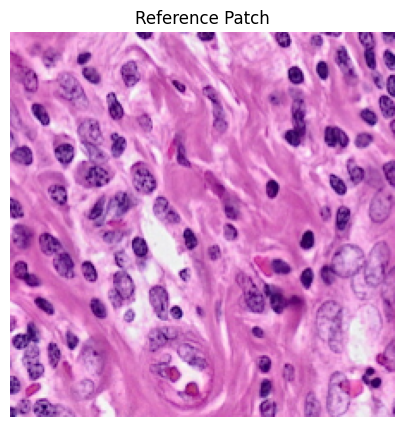

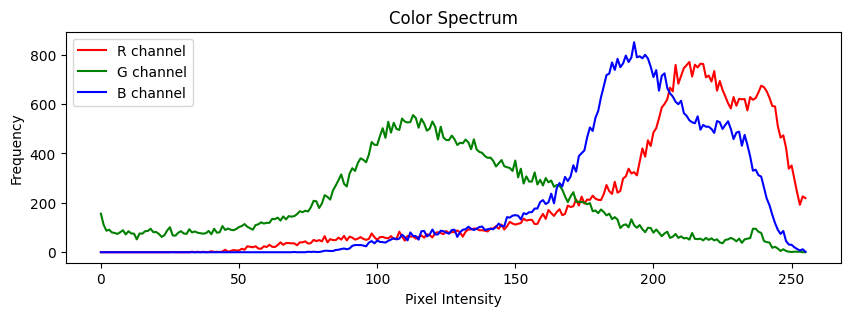

In [122]:
reference_case = 3
reference_patch = None

for current_case in h5_cases:
    h5_path = os.path.join(h5_folder, f"{current_case}.h5")
    with h5py.File(h5_path, 'r') as h5_file:
        # Assume the patches are stored in a dataset named 'img'
        patches = h5_file['img']
        if len(patches) < 5:
            sample_indices = list(range(len(patches)))
        else:
            sample_indices = random.sample(range(len(patches)), 5)
        plt.figure(figsize=(15, 3))
        for idx, patch_idx in enumerate(sample_indices):
            plt.subplot(1, 5, idx+1)
            plt.imshow(patches[patch_idx])
            plt.axis('off')
        plt.suptitle(f"Random patches from {current_case}")
        plt.show()
        
        # Pick one of the patches as reference if the case matches the global variable 'case'
        if current_case == h5_cases[reference_case] and reference_patch is None:
            reference_patch = patches[sample_indices[0]]

plot_reference_patch(reference_patch)

In [128]:
references += [reference_patch]
print(len(references))

10


In [133]:
reference_patch.shape

(224, 224, 3)

In [ ]:
from tqdm import tqdm
#from torchvahadane import TorchVahadaneNormalizer
from torch_staintools.normalizer import NormalizerBuilder
import torch
import cv2
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import convert_image_dtype

device = torch.device("cuda:0")
def postprocess(image_tensor): return convert_image_dtype(image_tensor, torch.uint8)\
    .squeeze().detach().cpu().permute(1, 2, 0).numpy()

# Initialize the normalizer with the reference tile
normalizer = NormalizerBuilder.build('vahadane', concentration_method='cd', use_cache=True,
                                              rng=1, device=device
                                              )
# normalizer = NormalizerBuilder.build('macenko', use_cache=True,
#                                              # use least square solver, along with cache, to perform
#                                              # normalization on-the-fly
#                                              concentration_method='ls')

reference_patch_tensor = ToTensor()(reference_patch).unsqueeze(0).to(device)
normalizer.fit(reference_patch_tensor)
    
# Loop over all subfolders and process .jpg images
for root, dirs, files in tqdm(list(os.walk(patches_folder)), desc="Processing folders", unit="folder"):
    for file in tqdm(files, desc="Processing images", unit="file", leave=False):
        if file.lower().endswith('.jpg'):
            patch_path = os.path.join(root, file)
            image = np.array(Image.open(patch_path).convert("RGB"))
            image_tensor = ToTensor()(image).unsqueeze(0).to(device)
            #norm_image = normalizer.transform(image.copy())
            norm_image = postprocess(normalizer(image_tensor))

            # Maintain folder structure in target_folder
            rel_dir = os.path.relpath(root, patches_folder)
            save_dir = os.path.join(target_folder, rel_dir)
            os.makedirs(save_dir, exist_ok=True)
            
            save_path = os.path.join(save_dir, file)
            Image.fromarray(norm_image.astype(np.uint8)).save(save_path)

Processing folders: 100%|██████████| 1060/1060 [08:53<00:00,  1.99folder/s] 
